# Human Protein Atlas Image Classification

- https://www.kaggle.com/c/human-protein-atlas-image-classification

## (1) A CNN Classifier and a Metric Learning Model, 1st Place Solution

- 각 샘플의 레이블을 예측하는 CNN 다중 레이블 분류 모델
- performance of the model was estimated using focal loss over the validation set
- A combined loss function of focal loss, Lovasz loss, and hard example log loss was used for training the model
- The output was thresholded using the ratio of labels in the training set

### Loss Functions(FocalLoss+Lovasz, ArcFaceLoss)

- did not use macro F1 soft loss
- because the batch size is small and some classes are rare
- used lovasz loss function because I thought although the IOU and F1 are not the same,but it can balance the Recall and Precision to some extend

In [ ]:
class ArcFaceLoss(nn.modules.Module):
    def __init__(self,s=30.0,m=0.5):
        super(ArcFaceLoss, self).__init__()
        self.classify_loss = nn.CrossEntropyLoss()
        self.s = s
        self.easy_margin = False
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, logits, labels, epoch=0):
        cosine = logits
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)

        one_hot = torch.zeros(cosine.size(), device='cuda')
        one_hot.scatter_(1, labels.view(-1, 1).long(), 1)
        # -------------torch.where(out_i = {x_i if condition_i else y_i) -------------
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s
        loss1 = self.classify_loss(output, labels)
        loss2 = self.classify_loss(cosine, labels)
        gamma=1
        loss=(loss1+gamma*loss2)/(1+gamma)
        return loss

class ArcMarginProduct(nn.Module):
    r"""Implement of large margin arc distance: :
        Args:
            in_features: size of each input sample
            out_features: size of each output sample
            s: norm of input feature
            m: margin
            cos(theta + m)
        """
    def __init__(self, in_features, out_features):
        super(ArcMarginProduct, self).__init__()
        self.weight = Parameter(torch.FloatTensor(out_features, in_features))
        # nn.init.xavier_uniform_(self.weight)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)

    def forward(self, features):
        cosine = F.linear(F.normalize(features), F.normalize(self.weight.cuda()))
        return cosine

 def __init__(self,....
     ... ...
    self.avgpool = nn.AdaptiveAvgPool2d(1)
    self.arc_margin_product=ArcMarginProduct(512, num_classes)
    self.bn1 = nn.BatchNorm1d(1024 * self.EX)
    self.fc1 = nn.Linear(1024 * self.EX, 512 * self.EX)
    self.bn2 = nn.BatchNorm1d(512 * self.EX)
    self.relu = nn.ReLU(inplace=True)
    self.fc2 = nn.Linear(512 * self.EX, 512)
    self.bn3 = nn.BatchNorm1d(512)

def forward(self, x):
    ... ...
    x = torch.cat((nn.AdaptiveAvgPool2d(1)(e5), nn.AdaptiveMaxPool2d(1)(e5)), dim=1)
    x = x.view(x.size(0), -1)
    x = self.bn1(x)
    x = F.dropout(x, p=0.25)
    x = self.fc1(x)
    x = self.relu(x)
    x = self.bn2(x)
    x = F.dropout(x, p=0.5)

    x = x.view(x.size(0), -1)

    x = self.fc2(x)
    feature = self.bn3(x)

    cosine=self.arc_margin_product(feature)
    if self.extract_feature:
        return cosine, feature
    else:
        return cosine

### Metric Learning

- Network:resnet50
- Augmentations:Rotate 90,flip
- Loss Functions:ArcFaceLoss
- Optimizer:Adam
- Scheduler:lr = 10e-5, 50 epochs.

**개념**
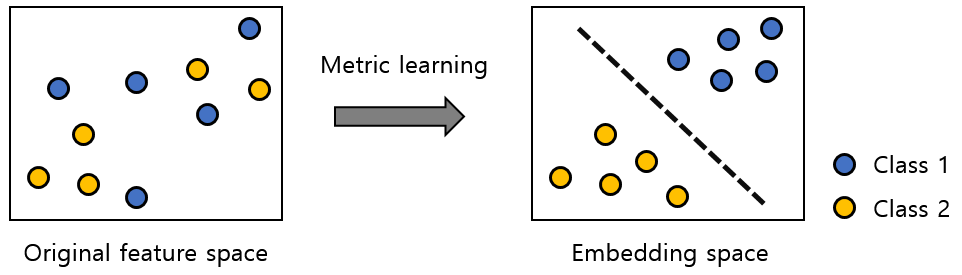

- Metric learning의 목적
- 데이터를 각 목표값에 따라 잘 구분되도록 변환하는 embedding 함수를 학스하는 것.
이때 함수는 단순 선형 변환이 아닌 deep neural network일 경우에 앞에 deep을 붙여 deep metric learning이라고 한다. 
    - 아래에서는 deep metric learning의 방법
        - contrastive embedding
        - triplet embedding
        - deep metric learning -> 회귀로 확장 log-ratio embedding

## (2) part of 4th place solution: GAPNet & dual loss ResNet

An ensemble of diverse and highly optimized CNN models, using hill climbing and weighted voting.

### GAPNet

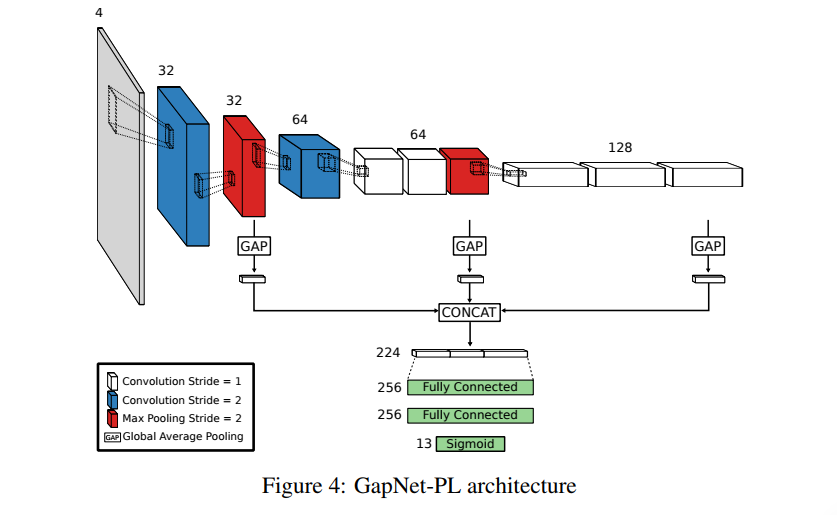

- GAPNet architecture is its ability for multiscale
- minor improvements adding SE-Blocks before the Average Pooling layers with nearly no computational cost
- used a weighted bce and f1 loss and a cosine annealing lr schedule and only trained for 20 epochs

### Dual Loss ResNet

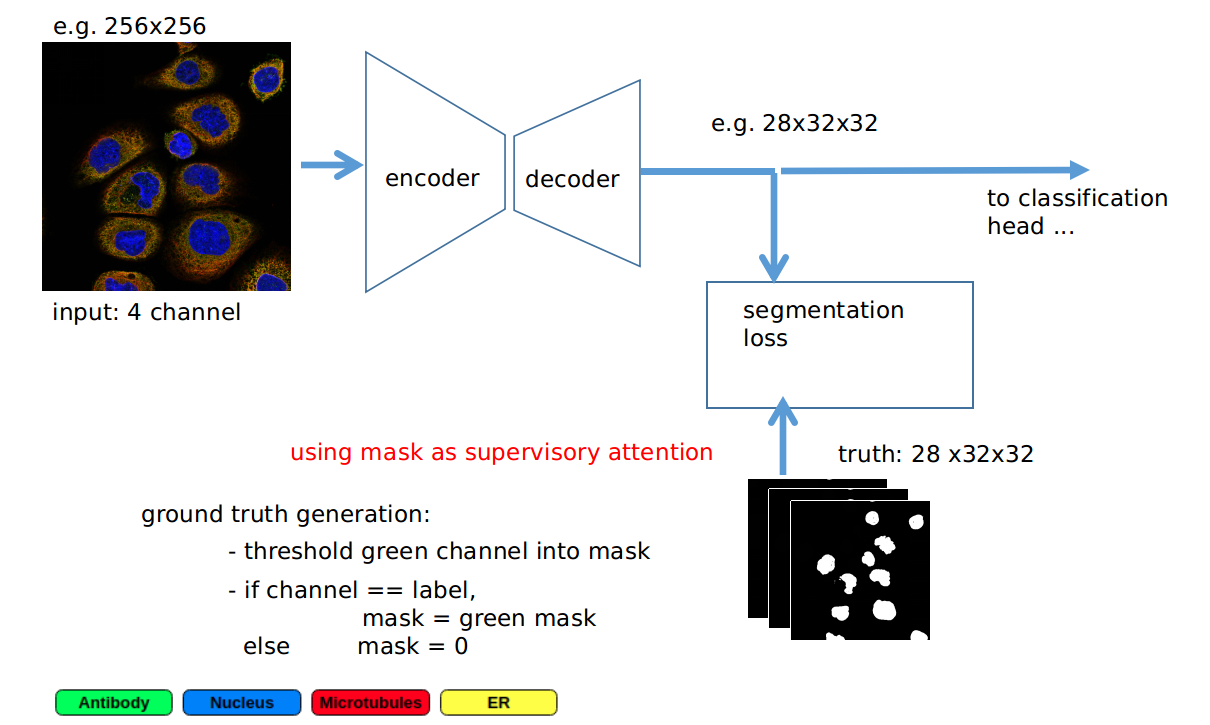

- Additionally to the "normal" classification loss
- downsampling of the green channel with the according labels as ground truth mask to have a segmentation loss
- supervised attention added quite some benefit to regularization
- computational cost was bearable

In [ ]:
##### resnet #####

def build_resnet(
     repetitions=(2, 2, 2, 2),
     include_top=True,
     input_tensor=None,
     input_shape=None,
     classes=1000,
     block_type='usual'):
    
    """
    TODO
    """
    
    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=197,
                                      data_format='channels_last',
                                      require_flatten=include_top)

    if input_tensor is None:
        img_input = Input(shape=input_shape, name='data')
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    
    # get parameters for model layers
    no_scale_bn_params = get_bn_params(scale=False)
    bn_params = get_bn_params()
    conv_params = get_conv_params()
    init_filters = 64

    if block_type == 'basic':
        conv_block = basic_conv_block
        identity_block = basic_identity_block
    else:
        conv_block = usual_conv_block
        identity_block = usual_identity_block
    
    # resnet bottom
    x = BatchNormalization(name='bn_data', **no_scale_bn_params)(img_input)
    x = ZeroPadding2D(padding=(3, 3))(x)
    x = Conv2D(init_filters, (7, 7), strides=(2, 2), name='conv0', **conv_params)(x)
    x = BatchNormalization(name='bn0', **bn_params)(x)
    x = Activation('relu', name='relu0')(x)
    x = ZeroPadding2D(padding=(1, 1))(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='valid', name='pooling0')(x)
    
    # resnet body
    for stage, rep in enumerate(repetitions):
        for block in range(rep):
            
            filters = init_filters * (2**stage)
            
            # first block of first stage without strides because we have maxpooling before
            if block == 0 and stage == 0:
                x = conv_block(filters, stage, block, strides=(1, 1))(x)
                
            elif block == 0:
                x = conv_block(filters, stage, block, strides=(2, 2))(x)
                
            else:
                x = identity_block(filters, stage, block)(x)
                
    x = BatchNormalization(name='bn1', **bn_params)(x)
    x = Activation('relu', name='relu1')(x)

    # resnet top
    if include_top:
        x = GlobalAveragePooling2D(name='pool1')(x)
        x = Dense(classes, name='fc1')(x)
        x = Activation('softmax', name='softmax')(x)

    # Ensure that the model takes into account any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
        
    # Create model.
    model = Model(inputs, x)

    return model


def ResNet18(input_shape, input_tensor=None, weights=None, classes=1000, include_top=True):
    model = build_resnet(input_tensor=input_tensor,
                         input_shape=input_shape,
                         repetitions=(2, 2, 2, 2),
                         classes=classes,
                         include_top=include_top,
                         block_type='basic')
    model.name = 'resnet18'

    if weights:
        load_model_weights(weights_collection, model, weights, classes, include_top)
    return model


def ResNet34(input_shape, input_tensor=None, weights=None, classes=1000, include_top=True):
    model = build_resnet(input_tensor=input_tensor,
                         input_shape=input_shape,
                         repetitions=(3, 4, 6, 3),
                         classes=classes,
                         include_top=include_top,
                         block_type='basic')
    model.name = 'resnet34'

    if weights:
        load_model_weights(weights_collection, model, weights, classes, include_top)
    return model


def ResNet50(input_shape, input_tensor=None, weights=None, classes=1000, include_top=True):
    model = build_resnet(input_tensor=input_tensor,
                         input_shape=input_shape,
                         repetitions=(3, 4, 6, 3),
                         classes=classes,
                         include_top=include_top)
    model.name = 'resnet50'

    if weights:
        load_model_weights(weights_collection, model, weights, classes, include_top)
    return model


def ResNet101(input_shape, input_tensor=None, weights=None, classes=1000, include_top=True):
    model = build_resnet(input_tensor=input_tensor,
                         input_shape=input_shape,
                         repetitions=(3, 4, 23, 3),
                         classes=classes,
                         include_top=include_top)
    model.name = 'resnet101'

    if weights:
        load_model_weights(weights_collection, model, weights, classes, include_top)
    return model


def ResNet152(input_shape, input_tensor=None, weights=None, classes=1000, include_top=True):
    model = build_resnet(input_tensor=input_tensor,
                         input_shape=input_shape,
                         repetitions=(3, 8, 36, 3),
                         classes=classes,
                         include_top=include_top)
    model.name = 'resnet152'

    if weights:
        load_model_weights(weights_collection, model, weights, classes, include_top)
    return model


###### resnext #####

def build_resnext(
     repetitions=(2, 2, 2, 2),
     include_top=True,
     input_tensor=None,
     input_shape=None,
     classes=1000,
     first_conv_filters=64,
     first_block_filters=64):
    
    """
    TODO
    """
    
    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=97,
                                      data_format='channels_last',
                                      require_flatten=include_top)

    if input_tensor is None:
        img_input = Input(shape=input_shape, name='data')
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    
    # get parameters for model layers
    no_scale_bn_params = get_bn_params(scale=False)
    bn_params = get_bn_params()
    conv_params = get_conv_params()
    init_filters = first_block_filters
    
    # resnext bottom
    x = BatchNormalization(name='bn_data', **no_scale_bn_params)(img_input)
    x = ZeroPadding2D(padding=(3, 3))(x)
    x = Conv2D(first_conv_filters, (7, 7), name='conv0', **conv_params)(x)
    x = BatchNormalization(name='bn0', **bn_params)(x)
    x = Activation('relu', name='relu0')(x)
    x = ZeroPadding2D(padding=(1, 1))(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='valid', name='pooling0')(x)
    
    # resnext body
    for stage, rep in enumerate(repetitions):
        for block in range(rep):
            
            filters = init_filters * (2**stage)
            
            # first block of first stage without strides because we have maxpooling before
            if stage == 0 and block == 0:
                x = conv_block(filters, stage, block, strides=(1, 1))(x)
                
            elif block == 0:
                x = conv_block(filters, stage, block, strides=(2, 2))(x)
                
            else:
                x = identity_block(filters, stage, block)(x)

    # resnext top
    if include_top:
        x = GlobalAveragePooling2D(name='pool1')(x)
        x = Dense(classes, name='fc1')(x)
        x = Activation('softmax', name='softmax')(x)

    # Ensure that the model takes into account any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
        
    # Create model
    model = Model(inputs, x)

    return model


def ResNeXt50(input_shape, input_tensor=None, weights=None, classes=1000, include_top=True):
    model = build_resnext(input_tensor=input_tensor,
                         input_shape=input_shape,
                         first_block_filters=128,
                         repetitions=(3, 4, 6, 3),
                         classes=classes,
                         include_top=include_top)
    model.name = 'resnext50'

    if weights:
        load_model_weights(weights_collection, model, weights, classes, include_top)
    return model


def ResNeXt101(input_shape, input_tensor=None, weights=None, classes=1000, include_top=True):
    model = build_resnext(input_tensor=input_tensor,
                         input_shape=input_shape,
                         first_block_filters=128,
                         repetitions=(3, 4, 23, 3),
                         classes=classes,
                         include_top=include_top)
    model.name = 'resnext101'

    if weights:
        load_model_weights(weights_collection, model, weights, classes, include_top)
    return model

## custom from christof
def ResNeXt18(input_shape, input_tensor=None, weights=None, classes=1000, include_top=True):
    model = build_resnext(input_tensor=input_tensor,
                         input_shape=input_shape,
                         first_block_filters=128,
                         repetitions=(2, 2, 2, 2),
                         classes=classes,
                         include_top=include_top)
    model.name = 'resnext18'

    return model

정말 대단하다..